In [1]:
import pandas as pd
import numpy as np
import optuna
from itertools import combinations
from matplotlib import pyplot as plt
import networkx as nx
from collections import defaultdict
from optuna.samplers import TPESampler
import plotly.express as px
import warnings
import plotly.graph_objects as go
from matplotlib import image as mpimg
import os
import io
from PIL import Image
import seaborn as sns
import re
import matplotlib.patches as mpatches

optuna.logging.set_verbosity(optuna.logging.WARN)

warnings.filterwarnings("ignore", category=optuna.exceptions.ExperimentalWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

/home/andrusha/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
file_data_name = "data/MY_data.xlsx"
# read element U.C sheet
uc = pd.read_excel(file_data_name, sheet_name="Element U.C.")

# read element mass U.C sheet
mass = pd.read_excel(file_data_name, sheet_name="Element Mass")

# read #node_1 & #node_2
nodes_1 = pd.read_excel(file_data_name, sheet_name="Element # NODE_1")
nodes_2 = pd.read_excel(file_data_name, sheet_name="Element # NODE_2")

# read #node_1 & #node_2 coordinates
nodes_1_coord = pd.read_excel(file_data_name, sheet_name="Element # NODE_1 coord.")
nodes_2_coord = pd.read_excel(file_data_name, sheet_name="Element # NODE_2 coord.")

N_PROFILES = len(mass)

pd.options.display.float_format = '{:.6f}'.format

In [5]:
def plot_lines(weights, data, feature_to_plot='weighted_score'):
    w_len = len(weights[0])
    num_rows = len(data)

    # Create an empty figure
    fig = go.Figure()
    line_x = pd.Series(data['N'].unique())
    for k in range(min(num_rows // w_len - 1, len(weights))):
        line_y = pd.Series()
        for i in range(k, num_rows, w_len):
            line_y = pd.concat([line_y, pd.Series([data.iloc[i][feature_to_plot]])])

        fig.add_trace(go.Scatter(x=line_x, y=line_y, mode='lines', name=f"{weights[k]}"))


    # Customize layout
    fig.update_layout(
        height=700,
        xaxis_title="N",
        yaxis_title=feature_to_plot,
        legend_title="Distributions",
        xaxis=dict(
            tickmode='linear',  # This ensures we show ticks at regular intervals
            tick0=1,            # Starting value of x-axis
            dtick=1             # Set the step size for ticks (1 for integers)
        )
    )

    # Show the plot
    fig.show()

def plot_parallel_coordinates_plot(full_data):
    full_data['N'] = pd.to_numeric(full_data['N'], errors='coerce')
    full_data['w_1'] = pd.to_numeric(full_data['w_1'], errors='coerce')
    full_data['w_2'] = pd.to_numeric(full_data['w_2'], errors='coerce')
    full_data['w_3'] = pd.to_numeric(full_data['w_3'], errors='coerce')
    full_data['w_4'] = pd.to_numeric(full_data['w_4'], errors='coerce')


    fig = px.parallel_coordinates(data_frame=full_data,
                                  dimensions=['mass', 'connect_deg', 'symmetry',
                                              'beam_cont', 'w_1', 'w_2', 'w_3', 'w_4', 'N'],
                                  color_continuous_scale=px.colors.diverging.RdBu, ############################################### schimba gradientu
                                  color_continuous_midpoint=3)

    fig.update_layout(
        height=700,
    )

    fig.show()

In [7]:
def select_column_combinations(df, n):
    """
    Generate all possible combinations of 'n' columns from the given DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    n (int): The number of columns to include in each combination.

    Returns:
    tuple: A tuple containing:
        - result_values (list of lists): A list where each element is a list of row values
          corresponding to a specific column combination.
        - result_columns (list of lists): A list where each element is a list of column names
          corresponding to a specific column combination.
    """
    # Generate all possible column combinations of size 'n'
    column_combinations = list(combinations(df.columns, n))

    # Extract values for each column combination
    result_values = [df[list(comb)].values.tolist() for comb in column_combinations]

    # Extract column names for each combination
    result_columns = [df[list(comb)].columns.tolist() for comb in column_combinations]

    return result_values, result_columns

def find_column_for_value_in_subset(row, value, possible_columns):
    """
    Find the first column in a given subset where the specified value appears.

    Parameters:
    row (pd.Series): A row from a DataFrame.
    value (any): The value to search for within the row.
    possible_columns (list): A list of column names to check.

    Returns:
    str or None: The column name where the value is found, or None if not found.
    """
    # Iterate over the specified columns in the row
    for col in possible_columns:
        if row[col] == value:  # Check if the value matches in the column
            return col  # Return the column name where the value was found

    return None  # Return None if the value is not found in any column

def check_uc(data, mask_value=999):
    """
    Apply a masking operation on the DataFrame 'data' based on unity_check (uc). Any value in 'data' where the corresponding
    value in 'uc' (excluding the first column) is greater than 1 is replaced with 999.

    Parameters:
    data (pd.DataFrame): The input DataFrame to be modified.

    Returns:
    pd.DataFrame: The modified DataFrame with values replaced where applicable.
    """
    # Ensure 'uc' is defined before use (assuming 'uc' is a global variable)
    mask = uc.iloc[:, 1:] <= 1  # Create a boolean mask where 'uc' values are <= 1

    # Apply the mask to 'data', replacing values where 'mask' is False with 999
    data.iloc[:, 1:] = data.iloc[:, 1:][mask].fillna(mask_value)

    return data

In [8]:
def visualize_graph(G):
    """
    Visualize a graph with node positions and labeled edges.

    Parameters:
    G (networkx.Graph): The input graph, where nodes have a 'pos' attribute
                        for positioning, and edges have 'element_id' and 'truss_type' attributes.

    Displays:
    A Matplotlib plot of the graph with labeled edges.
    """
    # Extract node positions from the 'pos' attribute
    pos = nx.get_node_attributes(G, 'pos')

    # Extract edge labels from 'element_id' and 'truss_type' attributes
    elements_id_labels = nx.get_edge_attributes(G, 'element_id')
    truss_types_labels = nx.get_edge_attributes(G, 'truss_type')

    # Concatenate 'element_id' and 'truss_type' for edge labeling
    concatenated_labels = {
        key: f'{str(value)}_{truss_types_labels[key]}'
        for key, value in elements_id_labels.items()
    }

    # Draw the graph with node positions and labels
    nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray")

    # Draw edge labels with concatenated information
    nx.draw_networkx_edge_labels(G, pos, edge_labels=concatenated_labels)

    # Display the plot
    # plt.show()

def create_graph(data_nodes_1, data_nodes_2, data_nodes_1_coord, data_nodes_2_coord, truss_types_data=None):
    """
    Creates a NetworkX graph from node and edge data, incorporating node positions
    and edge attributes such as element ID, mass, and truss type.

    Parameters:
    data_nodes_1 (pd.DataFrame): DataFrame containing edges and first node identifiers.
    data_nodes_2 (pd.DataFrame): DataFrame containing second node identifiers.
    data_nodes_1_coord (pd.DataFrame): Coordinates for the first set of nodes.
    data_nodes_2_coord (pd.DataFrame): Coordinates for the second set of nodes.
    truss_types_data (pd.DataFrame, optional): DataFrame containing truss type information for edges.

    Returns:
    tuple:
        - G (networkx.Graph): The constructed graph with nodes and edges.
        - data_nodes (pd.DataFrame): Processed DataFrame containing edge and node information.
    """
    G = nx.Graph()

    # Merge node and coordinate data into a single DataFrame
    data_nodes = pd.concat([
        data_nodes_1.iloc[:, :2],  # Edge and first node
        data_nodes_1_coord.iloc[:, 1],  # First node coordinates
        data_nodes_2.iloc[:, 1],  # Second node
        data_nodes_2_coord.iloc[:, 1]  # Second node coordinates
    ], axis=1)
    # Append truss type data if provided
    data_nodes = pd.concat([data_nodes, truss_types_data], axis=1)

    # Assign column names for clarity
    data_nodes.columns = ["edge", "node_1", "coord_node_1", "node_2", "coord_node_2", "truss_type"]

    # Get unique nodes from node_1 and node_2 columns
    unique_nodes = pd.concat([data_nodes["node_1"], data_nodes["node_2"]]).drop_duplicates().values

    # Get unique coordinate values, removing duplicates
    unique_coordinates = pd.concat([data_nodes["coord_node_1"], data_nodes["coord_node_2"]]).drop_duplicates().values

    # Clean coordinate data and convert to tuples
    unique_coordinates = [
        coordinates_tuple.replace(',', '.')
                         .replace('{', '').replace('}', '')
                         .split("_")
        for coordinates_tuple in unique_coordinates
    ]
    unique_coordinates = [(float(coord[0]), float(coord[2])) for coord in unique_coordinates]

    # Add nodes with position attributes
    for node, coordinates in zip(unique_nodes, unique_coordinates):
        G.add_node(node, pos=coordinates)

    # Add edges with attributes (element_id, mass, truss_type)
    for _, row in data_nodes.iterrows():
        if pd.notna(row["truss_type"]):  # Ensure truss type exists before adding edge
            G.add_edge(
                row["node_1"],
                row["node_2"],
                element_id=row["edge"],
                mass=mass.loc[int(row["edge"]) - 1, row["truss_type"]],  # Assuming 'mass' is defined globally
                truss_type=row["truss_type"]
            )
    return G, data_nodes

In [9]:
# Create a dataframe for structural complexity part
# Define possible truss types
truss_types = mass.columns[1:].tolist()

# Create a DataFrame where each column represents a truss type,
# and each column contains 9 repeated values of its name.
structural_complexity_data = pd.DataFrame({col: [col] * N_PROFILES for col in truss_types})

# Add an 'edge' column, numbering rows from 1 to the length of the DataFrame.
structural_complexity_data["edge"] = [i for i in range(1, len(structural_complexity_data) + 1)]

# Reorder columns to ensure 'edge' is the first column
columns_order = ["edge"] + [col for col in structural_complexity_data.columns if col != "edge"]
structural_complexity_data = structural_complexity_data[columns_order]

# Apply `check_uc()` function to structural complexity data
structural_complexity_data = check_uc(structural_complexity_data)

# Apply `check_uc()` function to `mass`
mass = check_uc(mass)
# structural_complexity_data
# truss_types

['HEA100', 'HEA120', 'HEA140', 'HEA180', 'HEA220']


In [7]:
# structural complexity metrics
def get_connection_degree_metric(G):
    """
    Computes the connection degree metric for a given graph G.

    The metric is based on the number of unique "truss_type" values
    associated with the edges connected to each node.

    Parameters:
    G (networkx.Graph): The input graph where edges have a "truss_type" attribute.

    Returns:
    int: The total connection degree metric, computed as the sum of unique truss types per node.
    """

    # Dictionary to store the count of unique truss types for each node
    connection_degree_dict = defaultdict(int)

    # Iterate over each node in the graph
    for node in G.nodes():
        # Retrieve edges connected to the node, including edge attributes
        temp = G.edges(node, data=True)

        # Extract unique truss types from connected edges (if the attribute exists)
        connection_degree_dict[node] = len({edge[2]["truss_type"] for edge in temp if "truss_type" in edge[2]})

    # Compute the total connection degree metric as the sum of all unique truss type counts per node
    return sum(connection_degree_dict.values())

def find_symmetric_nodes(G, center=(4, 1.25)):
    """
    Identifies symmetric node pairs in a graph based on reflection across a vertical axis.

    A node (x, y) is considered symmetric with another node (x', y) if:
        x' = 2 * center_x - x
        y' = y
    where (center_x, center_y) defines the vertical reflection axis.

    Parameters:
    G (networkx.Graph): The input graph with nodes having a "pos" attribute containing (x, y) coordinates.
    center (tuple): The (x, y) coordinates of the vertical axis of symmetry.

    Returns:
    dict: A dictionary where keys are nodes and values are their symmetric counterparts.
    """

    symmetric_pairs = {}  # Dictionary to store symmetric node pairs
    center_x, center_y = center  # Extract center coordinates

    # Iterate over all nodes and their positions
    for node, data in G.nodes(data=True):
        x, y = data["pos"]  # Get node coordinates

        # Compute mirrored x-coordinate across the vertical axis at center_x
        mirrored_x = 2 * center_x - x

        # Find the node with mirrored coordinates (mirrored_x, y)
        mirrored_node = next(
            (id for id, coord in G.nodes(data=True)
             if coord["pos"][0] == mirrored_x and coord["pos"][1] == y),
            None
        )

        # Store the symmetric pair if it hasn't been recorded already
        if mirrored_node and mirrored_node not in symmetric_pairs:
            symmetric_pairs[node] = mirrored_node

    return symmetric_pairs

def find_symmetric_elements(graph, symmetric_nodes):
    """
    Identifies symmetric edges in a graph based on node symmetry.

    An edge (start, end) is considered symmetric if its mirrored counterpart
    (mirrored_start, mirrored_end) exists in the graph.

    Parameters:
    graph (networkx.Graph): The input graph where edges have a "truss_type" attribute.
    symmetric_nodes (dict): A dictionary mapping nodes to their symmetric counterparts.

    Returns:
    list: A list of tuples where each tuple contains the truss types of symmetric edges.
    """

    symmetric_elements = []  # List to store pairs of symmetric truss types
    edges = set(graph.edges())  # Convert edges to a set for faster lookups
    edges_data = list(graph.edges(data=True))  # Get edges along with their attributes

    # Iterate over each edge and check for a symmetric counterpart
    for start, end, data in edges_data:
        # Find the mirrored nodes for the current edge's nodes
        mirrored_start = symmetric_nodes.get(start)
        mirrored_end = symmetric_nodes.get(end)

        # Check if the mirrored edge exists in the graph
        if mirrored_start and mirrored_end:
            mirrored_edge = (mirrored_start, mirrored_end)
            reversed_mirrored_edge = (mirrored_end, mirrored_start)

            if mirrored_edge in edges or reversed_mirrored_edge in edges:
                # Retrieve the truss type of the mirrored edge
                mirrored_edge_truss_type = graph.get_edge_data(mirrored_start, mirrored_end)["truss_type"]

                # Store the truss type pair
                symmetric_elements.append((data["truss_type"], mirrored_edge_truss_type))

    return symmetric_elements

def get_symmetric_metric(G):
    """
    Computes a symmetric metric for the graph G based on the symmetry of nodes and edges.

    The metric counts the number of edges whose truss types are different between the node
    and its mirrored counterpart. This can be used to assess the symmetry of a structural graph.

    Parameters:
    G (networkx.Graph): The input graph where nodes and edges have position and truss_type attributes.

    Returns:
    int: The symmetric metric value, which is the count of edges with differing truss types between
         mirrored node pairs.
    """

    # Find symmetric nodes in the graph (nodes with mirrored counterparts)
    symmetric_nodes = find_symmetric_nodes(G)

    # Find symmetric edges based on the symmetric nodes
    symmetric_elements = find_symmetric_elements(G, symmetric_nodes)

    # Compute the symmetric metric by counting edges with different truss types for mirrored nodes
    symmetric_metric = sum([1 if symmetric_element[0] != symmetric_element[1] else 0
                            for symmetric_element in symmetric_elements])

    return symmetric_metric

def iterate_over_beam(graph, start_node):
    """
    Iterates over the edges connected to the starting node in the graph, and identifies edges
    that are part of the same horizontal beam (i.e., share the same y-coordinate).

    The function considers edges whose start node and end node lie on the same horizontal line
    as the start node and ensures the nodes are ordered from left to right.

    Parameters:
    graph (networkx.Graph): The input graph with node positions and edge attributes.
    start_node (tuple): The starting node, which is a tuple (node_id, node_data) where node_data
                        contains the 'pos' attribute with (x, y) coordinates.

    Returns:
    list: A list of truss types for all edges in the same horizontal beam, ordered from left to right.
    """

    # Get the coordinates of the starting node
    start_x, start_y = start_node[1]["pos"]

    # Initialize a list to store subsequent edges that are on the same horizontal beam
    subsequent_edges = []

    # Iterate over all edges in the graph
    for u, v in graph.edges():
        # Get the coordinates of the nodes connected by this edge
        u_x, u_y = graph.nodes[u]['pos']
        v_x, v_y = graph.nodes[v]['pos']

        # Check if both nodes (u, v) are on the same horizontal line (y-coordinate)
        # and if the edge is ordered correctly (from left to right relative to the start node)
        if start_y == u_y == v_y and start_x <= u_x and start_x <= v_x:
            # Add the truss type of the edge to the subsequent_edges list
            subsequent_edges.append(graph.get_edge_data(u, v)["truss_type"])

    return subsequent_edges

def get_beam_continuity_metric(G):
    """
    Calculates a beam continuity metric for the graph G by analyzing the horizontal beams
    at the top-left and bottom-left corners of the graph.

    The metric rewards continuity in truss types along the horizontal beams. If the truss type
    changes between consecutive edges in the beam, the metric is incremented.

    Parameters:
    G (networkx.Graph): The input graph where nodes have positions and edges have truss type attributes.

    Returns:
    int: The beam continuity metric, which measures the consistency of truss types in horizontal beams.
    """

    # Identify the top-left node (smallest x-coordinate, largest y-coordinate)
    top_left_node = min(G.nodes(data=True), key=lambda x: (x[1]['pos'][0], -x[1]['pos'][1]))

    # Identify the bottom-left node (smallest x-coordinate, smallest y-coordinate)
    bottom_left_node = min(G.nodes(data=True), key=lambda x: (x[1]['pos'][0], x[1]['pos'][1]))

    # Iterate over the top horizontal beam starting from the top-left node
    top_beam = iterate_over_beam(G, top_left_node)

    # Iterate over the bottom horizontal beam starting from the bottom-left node
    bottom_beam = iterate_over_beam(G, bottom_left_node)

    # Initialize the beam continuity metric, starting with a value of 2 (representing the first pair)
    beam_continuity_metric = 2

    # Iterate through the top beam and bottom beam to check for continuity of truss types
    for i in range(1, len(top_beam)):
        # Increment the metric if the truss type changes in the top beam
        if top_beam[i-1] != top_beam[i]:
            beam_continuity_metric += 1
        # Increment the metric if the truss type changes in the bottom beam
        if bottom_beam[i-1] != bottom_beam[i]:
            beam_continuity_metric += 1

    return beam_continuity_metric

In [8]:
def total_objective(trial, choices_complexity, n_required):
    """
    This function calculates multiple metrics for a given set of choices (e.g., truss types) based on the trial
    and returns a tuple of graph mass, connection degree metric, symmetry metric, and beam continuity metric.

    Parameters:
    trial (optuna.trial.Trial): The current trial object used for hyperparameter optimization.
    choices_complexity (list): A list of complexity choices for each parameter.

    Returns:
    tuple: A tuple containing four metrics:
        - graph_mass: The total mass of the graph edges.
        - connection_metric: The connection degree metric.
        - symmetry_metric: The symmetry metric.
        - beam_continuity_metric: The beam continuity metric.
    """

    # Get the parameter names for the edges (mass information) and convert them to a list of strings
    param_names = mass.iloc[:, 0].values.astype(str).flatten().tolist()
    truss_types_var = []  # This list will hold the suggested truss types for each parameter
    # Iterate over parameter names and their corresponding complexity choices
    for param_name, choice in zip(param_names, choices_complexity):
        # Filter out any invalid choices (999 values)
        filtered_choice = [choice_el for choice_el in choice if choice_el != 999]

        # If there are valid choices, suggest a categorical value for each parameter
        if len(filtered_choice) > 0:
            # `trial.suggest_categorical` suggests a truss type for each parameter
            suggested = trial.suggest_categorical(f"s_{param_name}", filtered_choice)
            truss_types_var.append(suggested)  # Append the suggested truss type to the list

    # Create a DataFrame with the selected truss types for each parameter
    truss_types_var_df = pd.DataFrame(truss_types_var, columns=["truss_type"])

    # Create a graph using the selected truss types and the provided node data
    G, data_nodes = create_graph(nodes_1, nodes_2, nodes_1_coord, nodes_2_coord, truss_types_var_df)

    # Calculate the various metrics for the generated graph
    connection_metric = get_connection_degree_metric(G)
    symmetry_metric = get_symmetric_metric(G)
    beam_continuity_metric = get_beam_continuity_metric(G)

    # Calculate the total mass of the graph edges
    graph_mass = sum([data["mass"] for _, _, data in G.edges(data=True)])

    unique_truss_types = set(truss_types_var)
    n_distinct = len(unique_truss_types)


    if n_distinct < n_required:
        PENALTY_MULTIPLIER = 1e9
        penalty = (n_required - n_distinct) * PENALTY_MULTIPLIER

        graph_mass += penalty
        connection_metric += penalty
        symmetry_metric += penalty
        beam_continuity_metric += penalty

    # Return the calculated metrics as a tuple
    return graph_mass, connection_metric, symmetry_metric, beam_continuity_metric

In [9]:
def run_total_tpe_optimizer(n, data_complexity, n_trials=100):

    # Select possible column combinations from the data complexity based on the number of columns (n)
    choices_list_complexity, columns_list_complexity = select_column_combinations(data_complexity.iloc[:, 1:], n)

    # Lists to store best trial values and parameters for each set of choices
    best_trial_values = []
    best_trial_params = []
    # Iterate over each set of complexity choices
    for i in range(len(choices_list_complexity)):

        sampler = TPESampler(consider_prior=False,
                             consider_magic_clip=False,
                             multivariate=True,
                             group=True,
                             consider_endpoints=False,
                             constant_liar=False,
                             n_startup_trials=100,
                             n_ei_candidates=100,
                             seed=42,
                             )
        study = optuna.create_study(sampler=sampler, directions=["minimize"] * 4)  # We are minimizing 4 objectives

        # Define the objective function to optimize, which takes the current trial and complexity choices as inputs
        def objective_with_choice(trial):
            return total_objective(trial, choices_list_complexity[i], n)

        # Optimize the objective function for the current set of choices
        study.optimize(objective_with_choice, n_trials=n_trials)

        # Store the best trial values and parameters from the optimization process
        best_trial_values += [trial.values for trial in study.best_trials]
        best_trial_params += [trial.params for trial in study.best_trials]

    # Return the best trial values and parameters for all sets of complexity choices
    return best_trial_values, best_trial_params

In [10]:
import time
def minmax_scale(column_name):

    col_min = column_name.min()
    col_max = column_name.max()

    if col_min == col_max:
        return pd.Series([0.5] * len(column_name), index=column_name.index)  # Avoid division by zero

    return ((column_name - col_min) / (col_max - col_min))

def compute_post_optimization_score(optimized_data_column, weights):
    scaled_values = optimized_data_column[["mass", "connect_deg", "symmetry", "beam_cont"]].apply(minmax_scale)
    score = (scaled_values * weights).sum(axis=1)
    optimized_data_column["weighted_score"] = score
    return optimized_data_column.loc[[score.idxmin()]]

In [11]:
# create algorithm execution function as above
def run_algorithm(N=1, N_TRIALS=10, weights=None):
    start_time = time.perf_counter()

    best_trial_values, best_trial_params = run_total_tpe_optimizer(N,
                                                               structural_complexity_data,
                                                               n_trials=N_TRIALS)

    end_time = time.perf_counter()
    execution_time = end_time - start_time

    values = []
    params = []
    for i in range(len(best_trial_values)):
        if len(best_trial_params[i]) == N_PROFILES:
            values.append(best_trial_values[i])
            params.append(best_trial_params[i])
    data = list(zip(values, params))

    params_df = pd.DataFrame(params)

    distinct_s_count = params_df.nunique(axis=1)
    params_df['N'] = distinct_s_count

    values_df = pd.DataFrame([val if isinstance(val, (list, tuple)) else [val] for val, _ in data])

    values_df.columns = ['mass', 'connect_deg', 'symmetry', 'beam_cont']

    # Concatenate both DataFrames along columns.
    final_df = pd.concat([values_df, params_df], axis=1)
    final_df = final_df.drop_duplicates(keep="first").reset_index(drop=True)

    result_df = pd.DataFrame(columns=list(final_df.columns) + [f'w_{i}' for i in range(1, len(weights[0]) + 1)])
    for weight_set in weights:
        post_optimization_score = compute_post_optimization_score(final_df, weight_set)
        weight_df = pd.DataFrame([weight_set], columns=[f'w_{i}' for i in range(1, len(weights[0]) + 1)])
        post_optimization_score = pd.concat([post_optimization_score.reset_index(drop=True), weight_df], axis=1)
        result_df = pd.concat([result_df, post_optimization_score], axis=0, ignore_index=True)

    print(f"Execution time of algorithm: {execution_time:.6f} seconds", sep='\n')
    return result_df


# run_algorithm(N=5, N_TRIALS=1000, weights=[[0.1, 0.0, 0.0, 0.9],
#                                            [0.9, 0.0, 0.0, 0.1]])

# display(compute_post_optimization_score(final_df, [0.1, 0.0, 0.0, 0.9]))

In [12]:
#################################################### SETU UP UR WEIGHTS
your_weights = [     [1.00, 0.00, 0.00, 0.00],                                       #1
                     [0.00, 1.00, 0.00, 0.00],                                  #2
                     [0.00, 0.00, 1.00, 0.00],                                  #3
                     [0.00, 0.00, 0.00, 1.00],                                  #4
                     [0, 0, 0, 1.0],                                            #5
                     [0, 0, 0.25, 0.75],                                        #6
                     [0, 0, 0.5, 0.5],                                          #7
                     [0, 0, 0.75, 0.25],                                        #8
                     [0, 0, 1.0, 0],                                            #9
                     [0, 0.25, 0, 0.75],                                        #10
                     [0, 0.25, 0.25, 0.5],                                      #11
                     [0, 0.25, 0.5, 0.25],                                      #12
                     [0, 0.25, 0.75, 0],                                        #13
                     [0, 0.5, 0, 0.5],                                          #14
                     [0, 0.5, 0.25, 0.25],                                      #15
                     [0, 0.5, 0.5, 0],                                          #16
                     [0, 0.75, 0, 0.25],                                        #17
                     [0, 0.75, 0.25, 0],                                        #18
                     [0, 1.0, 0, 0],                                            #19
                     [0.25, 0, 0, 0.75],                                        #20
                     [0.25, 0, 0.25, 0.5],                                      #21
                     [0.25, 0, 0.5, 0.25],                                      #22
                     [0.25, 0, 0.75, 0],                                        #23
                     [0.25, 0.25, 0, 0.5],                                      #24
                     [0.25, 0.25, 0.25, 0.25],                                  #25
                     [0.25, 0.25, 0.5, 0],                                      #26
                     [0.25, 0.5, 0, 0.25],                                      #27
                     [0.25, 0.5, 0.25, 0],                                      #28
                     [0.25, 0.75, 0, 0],                                        #29
                     [0.5, 0, 0, 0.5],                                          #30
                     [0.5, 0, 0.25, 0.25],                                      #31
                     [0.5, 0, 0.5, 0],                                          #32
                     [0.5, 0.25, 0, 0.25],                                      #33
                     [0.5, 0.25, 0.25, 0],                                      #34
                     [0.5, 0.5, 0, 0],                                          #35
                     [0.75, 0, 0, 0.25],                                        #36
                     [0.75, 0, 0.25, 0],                                        #37
                     [0.75, 0.25, 0, 0],                                        #38
                     [1.0, 0, 0, 0]]                                            #39

your_weights = [[0.25, 0.5, 0.25, 0],                                      #28
                     [0.25, 0.25, 0, 0.5],                                        #29
                     [0.5, 0, 0, 0.5],
                      [0, 1.0, 0, 0],                                            #19#30
                     [0.5, 0, 0.25, 0.25]]

random_weights = [np.random.dirichlet(np.ones(4), size=1)[0].tolist() for _ in range(4)]

#################################################### SETU UP UR PARAMS
N_TRIALS = 50
WEIGHTS = your_weights # CHANGE VARIABLE NAME
####################################################
column_names = (["mass", "connect_deg", "symmetry", "beam_cont", "weighted_score"] +
                [f"s_{i}" for i in range(1, N_PROFILES+1)] +
                ["w_1", "w_2", "w_3", "w_4", "N"])

parallel_coordinates_data = pd.DataFrame(columns=column_names)
#run for all N_TRUSS_TYPES
# for n in range(1, len(truss_types) + 1):
for n in range(1, len(truss_types) + 1):
    data = run_algorithm(N=n,
                         N_TRIALS=N_TRIALS,
                         weights=WEIGHTS)
    parallel_coordinates_data = pd.concat([parallel_coordinates_data, data], axis=0, ignore_index=True)


#### PLOTS
plot_parallel_coordinates_plot(parallel_coordinates_data)
plot_lines(WEIGHTS, parallel_coordinates_data, feature_to_plot='mass')
display(parallel_coordinates_data)


Execution time of algorithm: 0.676960 seconds
Execution time of algorithm: 1.353530 seconds
Execution time of algorithm: 1.330272 seconds
Execution time of algorithm: 0.676700 seconds
Execution time of algorithm: 0.131902 seconds


mass  connect_deg  symmetry  beam_cont  weighted_score     s_1  \
0  1169.856177     6.000000  0.000000   2.000000        0.375000  HEA180   
1  1169.856177     6.000000  0.000000   2.000000        0.375000  HEA180   
2  1169.856177     6.000000  0.000000   2.000000        0.250000  HEA180   
3  1169.856177     6.000000  0.000000   2.000000        0.500000  HEA180   
4  1169.856177     6.000000  0.000000   2.000000        0.250000  HEA180   
5  1122.736552     8.000000  0.000000   2.000000        0.089391  HEA180   
6  1122.736552     8.000000  0.000000   2.000000        0.089391  HEA180   
7   853.877756    10.000000  1.000000   2.000000        0.007154  HEA180   
8  1094.464777     8.000000  1.000000   3.000000        0.000000  HEA180   
9   877.714502    11.000000  0.000000   2.000000        0.022370  HEA180   
10  887.227164    11.000000  0.000000   2.000000        0.168265  HEA180   
11  845.831506    11.000000  2.000000   2.000000        0.092115  HEA180   
12  756.015510    13.000000  0.000000   2.000000        0.000000  HEA180   
13 1083.663177    10.000000  1.000000   2.000000        0.000000  HEA180   
14  756.015510    13.000000  0.000000   2.000000        0.000000  HEA180   
15  827.222860    12.000000  2.000000   4.000000        0.200021  HEA220   
16  760.827012    13.000000  2.000000   2.000000        0.083333  HEA180   
17  760.827012    13.000000  2.000000   2.000000        0.000000  HEA180   
18  820.820637    12.000000  3.000000   3.000000        0.000000  HEA180   
19  799.432764    15.000000  0.000000   2.000000        0.038788  HEA180   
20  901.982335    14.000000  2.000000   3.000000        0.125000  HEA180   
21  901.982335    14.000000  2.000000   3.000000        0.500000  HEA180   
22  901.982335    14.000000  2.000000   3.000000        0.500000  HEA180   
23  901.982335    14.000000  2.000000   3.000000        0.000000  HEA180   
24  901.982335    14.000000  2.000000   3.000000        0.375000  HEA180   

       s_2     s_3     s_4     s_5     s_6     s_7     s_8     s_9      w_1  \
0   HEA180  HEA180  HEA180  HEA180  HEA180  HEA180  HEA180  HEA180 0.250000   
1   HEA180  HEA180  HEA180  HEA180  HEA180  HEA180  HEA180  HEA180 0.250000   
2   HEA180  HEA180  HEA180  HEA180  HEA180  HEA180  HEA180  HEA180 0.500000   
3   HEA180  HEA180  HEA180  HEA180  HEA180  HEA180  HEA180  HEA180 0.000000   
4   HEA180  HEA180  HEA180  HEA180  HEA180  HEA180  HEA180  HEA180 0.500000   
5   HEA180  HEA180  HEA180  HEA180  HEA100  HEA180  HEA180  HEA180 0.250000   
6   HEA180  HEA180  HEA180  HEA180  HEA100  HEA180  HEA180  HEA180 0.250000   
7   HEA180  HEA120  HEA120  HEA120  HEA120  HEA120  HEA120  HEA180 0.500000   
8   HEA180  HEA180  HEA100  HEA180  HEA180  HEA180  HEA180  HEA180 0.000000   
9   HEA180  HEA100  HEA100  HEA100  HEA100  HEA100  HEA180  HEA180 0.500000   
10  HEA180  HEA140  HEA140  HEA140  HEA120  HEA140  HEA140  HEA140 0.250000   
11  HEA180  HEA120  HEA120  HEA100  HEA120  HEA120  HEA120  HEA180 0.250000   
12  HEA180  HEA120  HEA120  HEA100  HEA100  HEA100  HEA120  HEA120 0.500000   
13  HEA180  HEA180  HEA180  HEA180  HEA120  HEA100  HEA180  HEA180 0.000000   
14  HEA180  HEA120  HEA120  HEA100  HEA100  HEA100  HEA120  HEA120 0.500000   
15  HEA180  HEA120  HEA100  HEA120  HEA120  HEA120  HEA120  HEA120 0.250000   
16  HEA180  HEA100  HEA100  HEA120  HEA100  HEA100  HEA120  HEA140 0.250000   
17  HEA180  HEA100  HEA100  HEA120  HEA100  HEA100  HEA120  HEA140 0.500000   
18  HEA180  HEA120  HEA100  HEA180  HEA120  HEA100  HEA120  HEA140 0.000000   
19  HEA180  HEA100  HEA100  HEA120  HEA120  HEA120  HEA140  HEA140 0.500000   
20  HEA180  HEA100  HEA140  HEA120  HEA220  HEA180  HEA120  HEA120 0.250000   
21  HEA180  HEA100  HEA140  HEA120  HEA220  HEA180  HEA120  HEA120 0.250000   
22  HEA180  HEA100  HEA140  HEA120  HEA220  HEA180  HEA120  HEA120 0.500000   
23  HEA180  HEA100  HEA140  HEA120  HEA220  HEA180  HEA120  HEA120 0.000000   
24  HEA180  HEA100  HEA140  HEA120  HEA220  HEA180  HEA120

/tmp/ipykernel_12538/1418143679.py:8: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



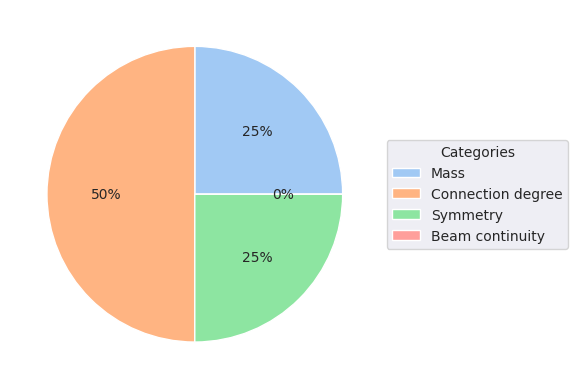

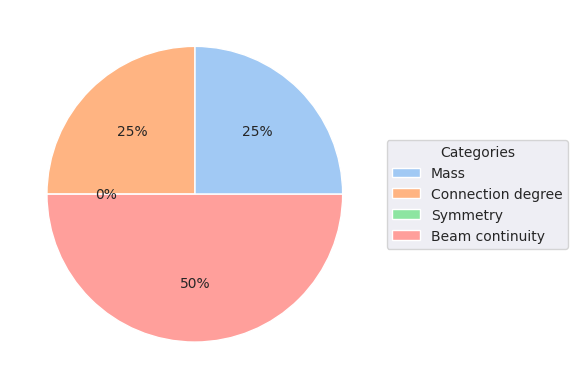

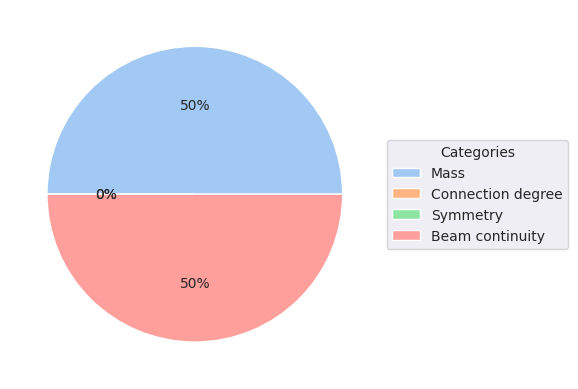

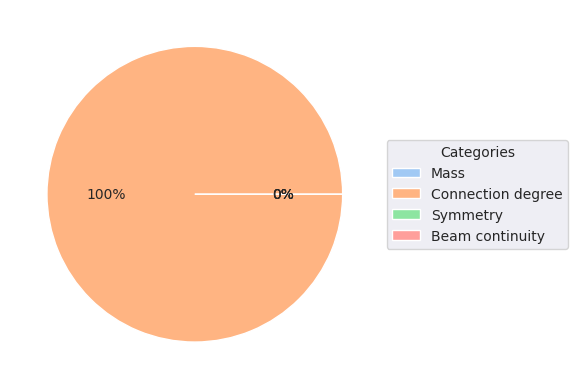

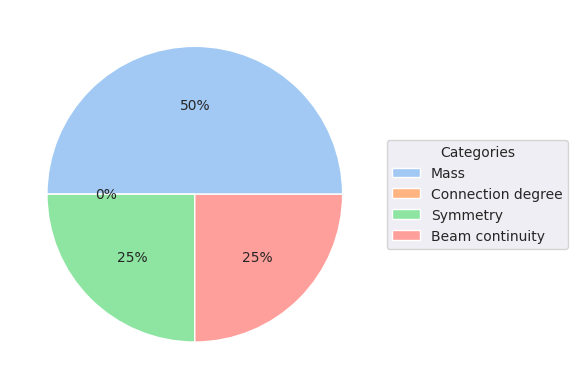

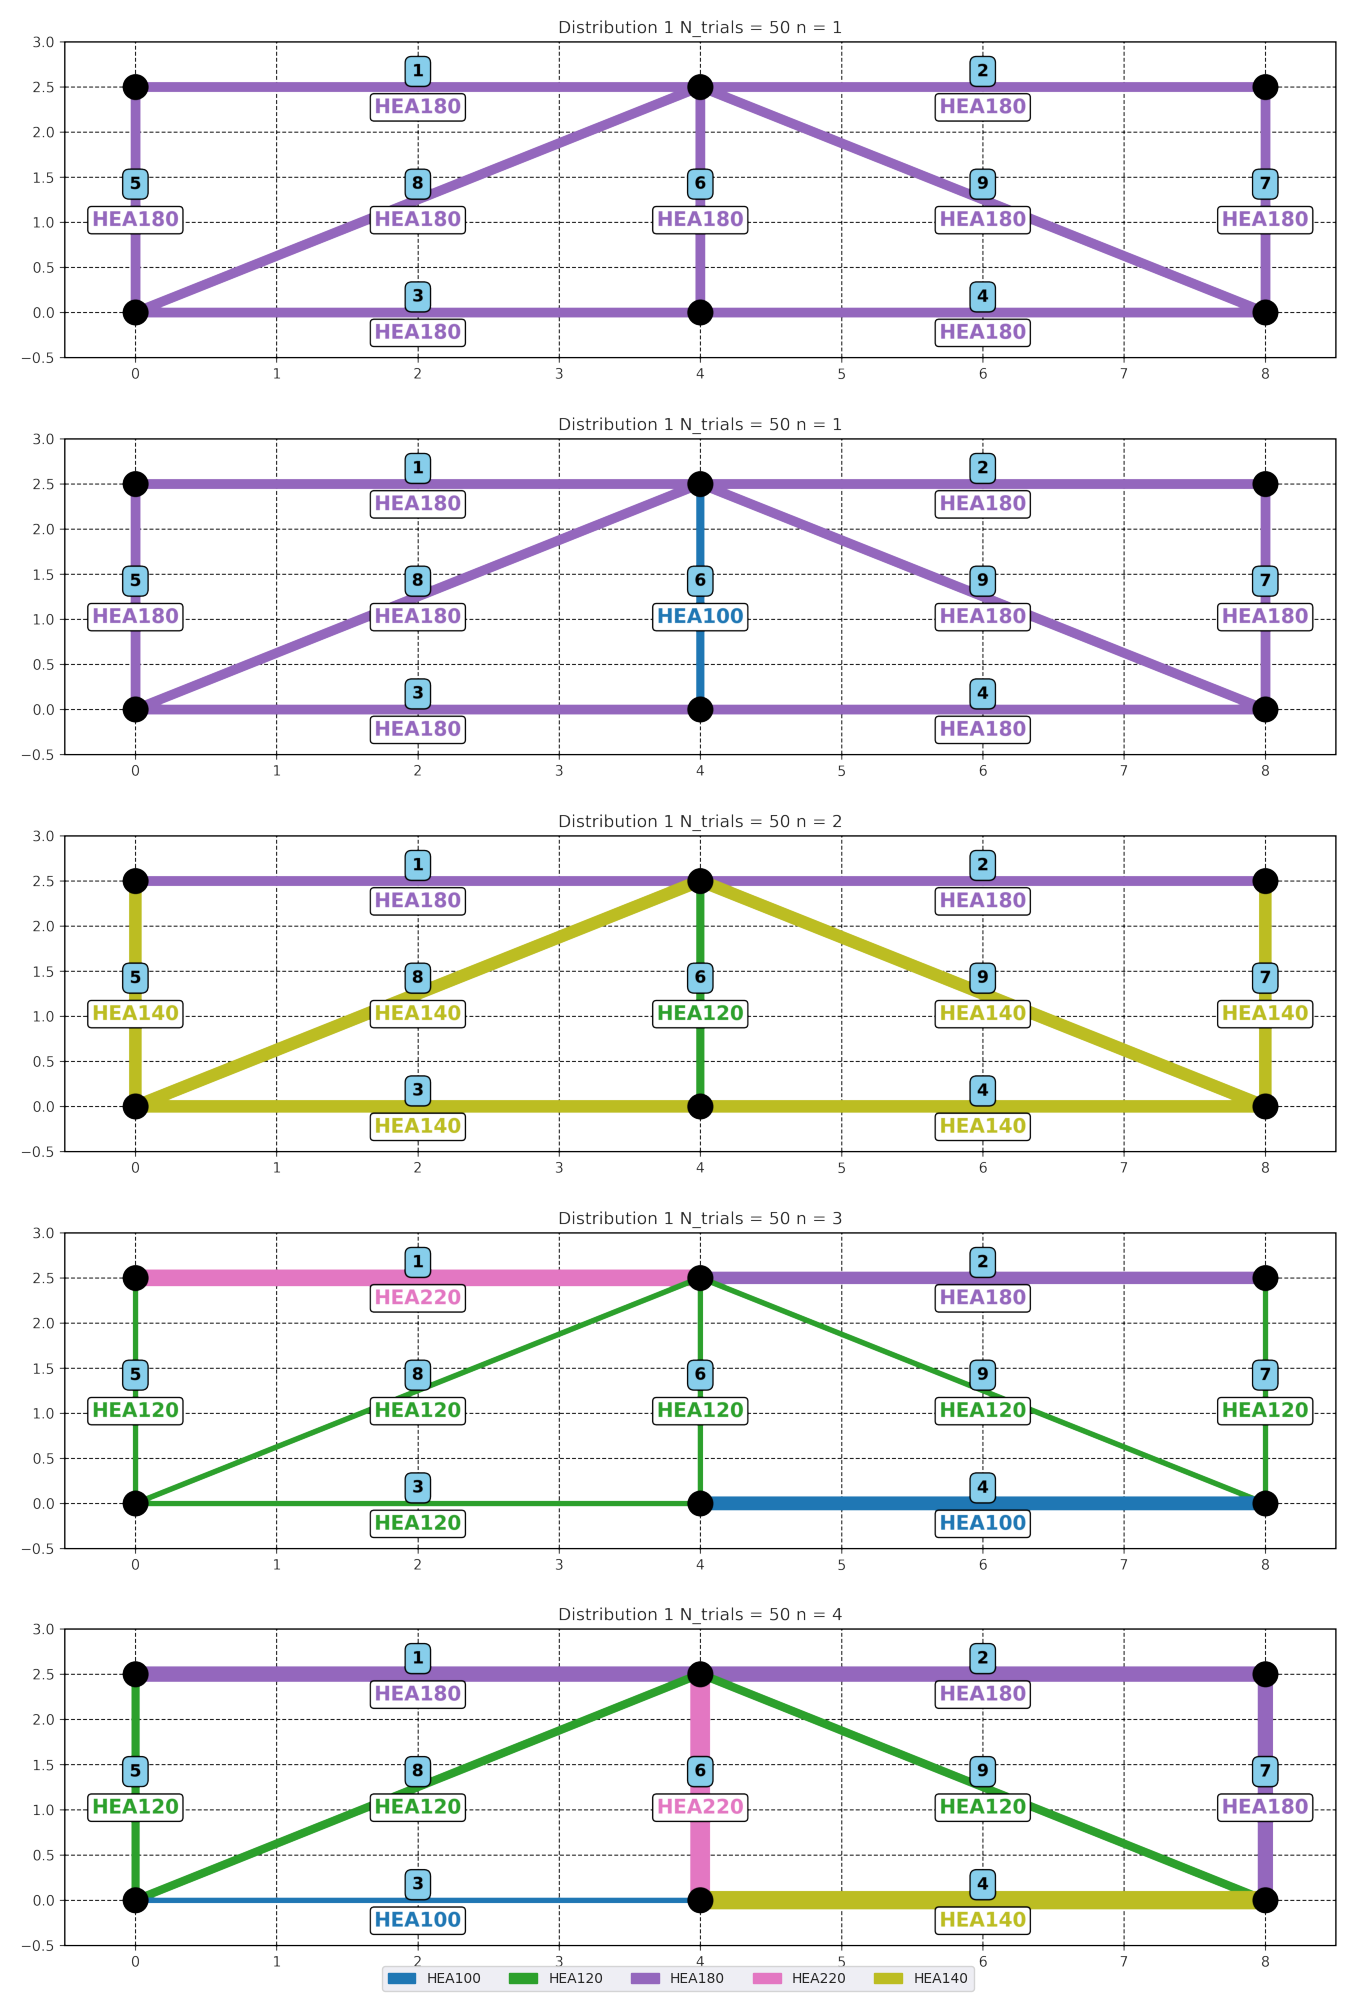

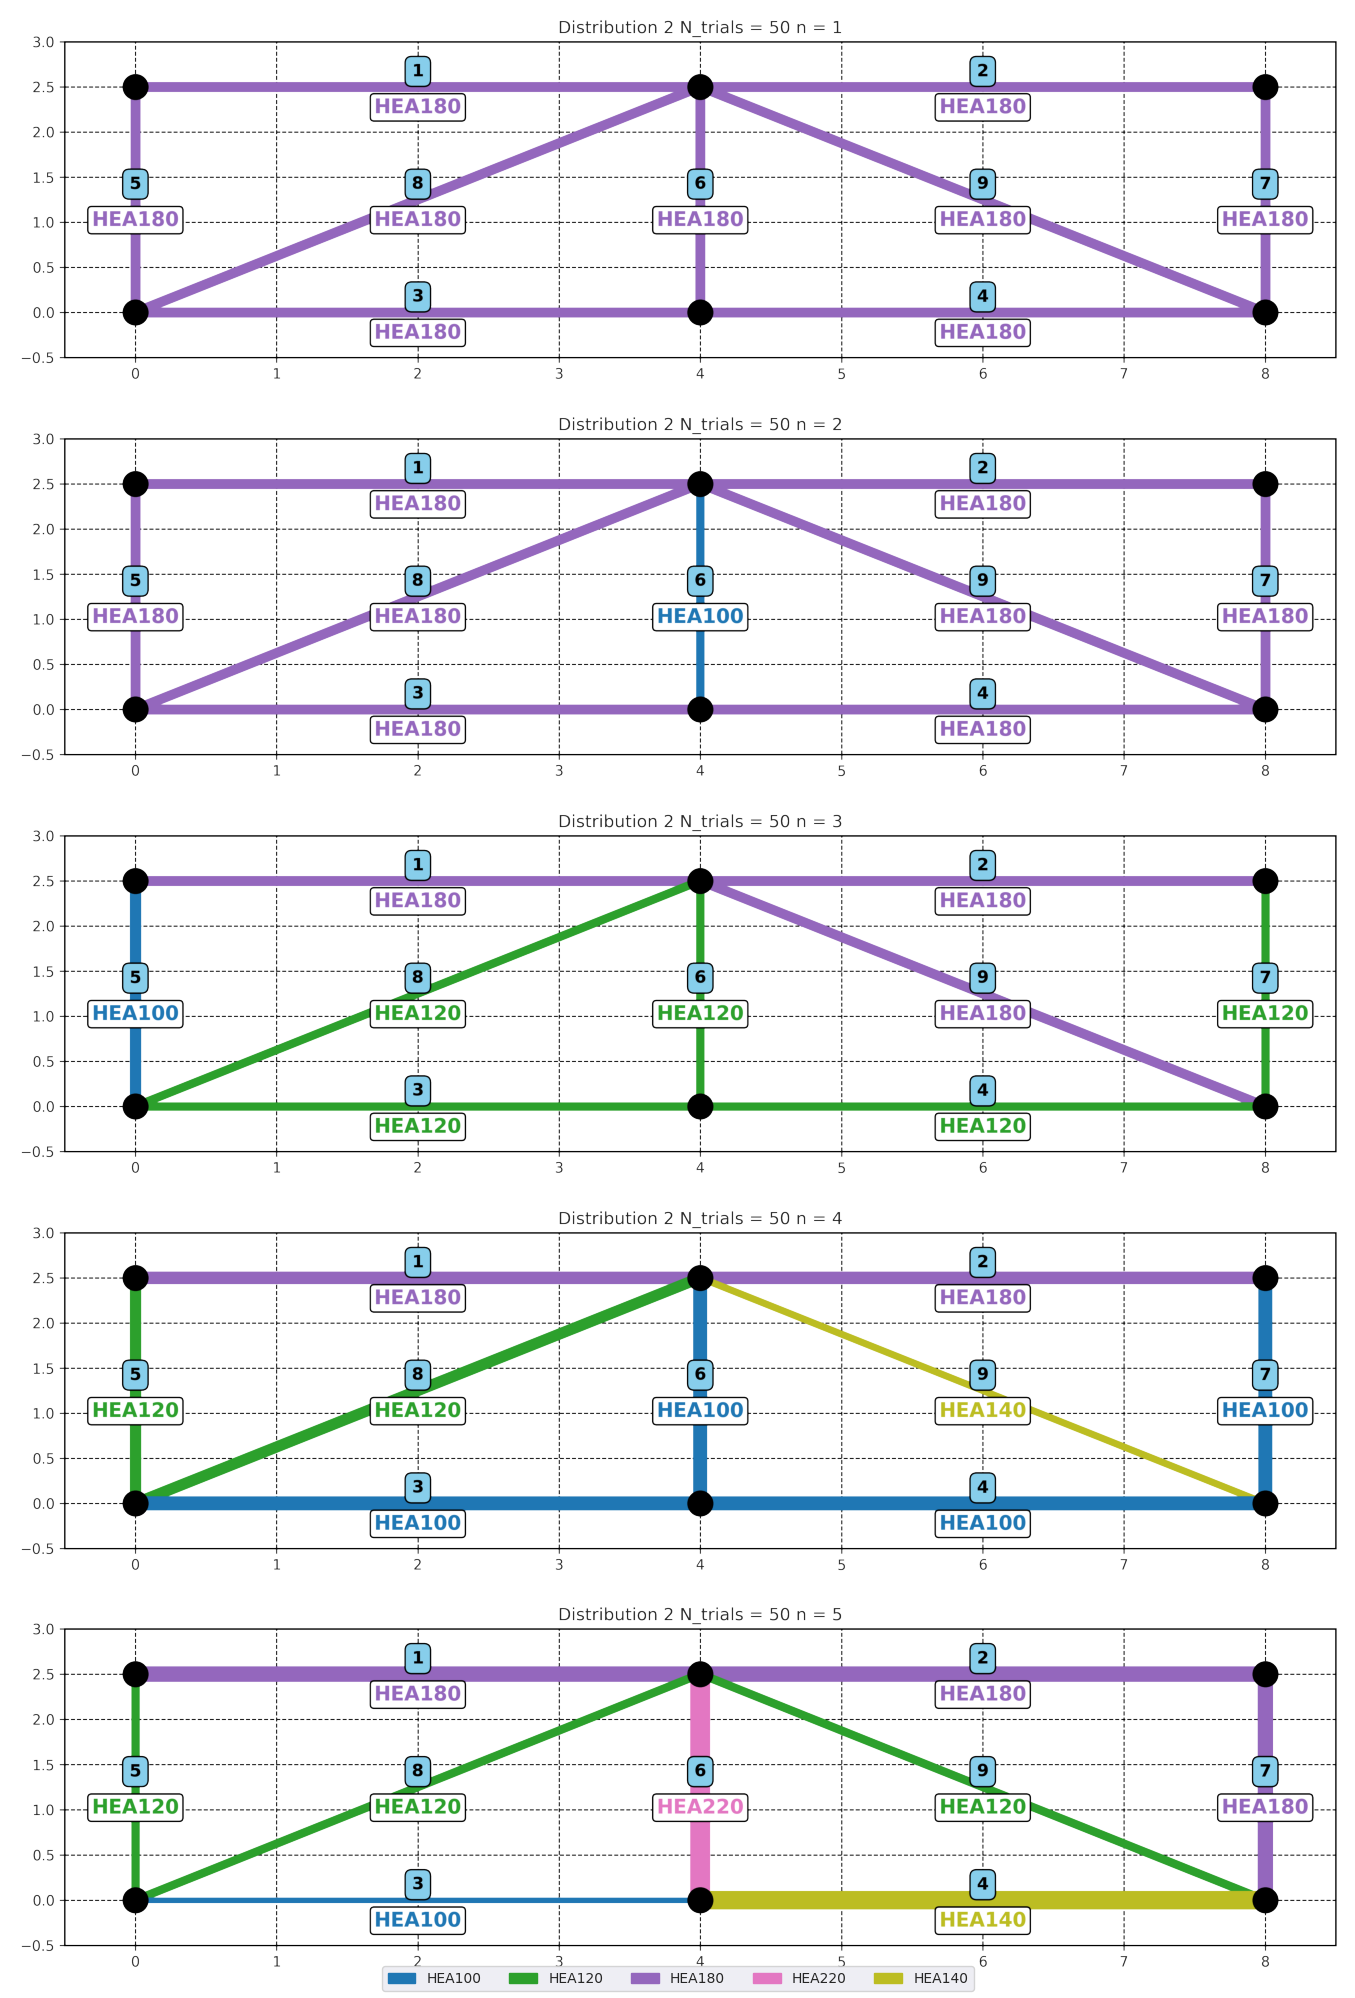

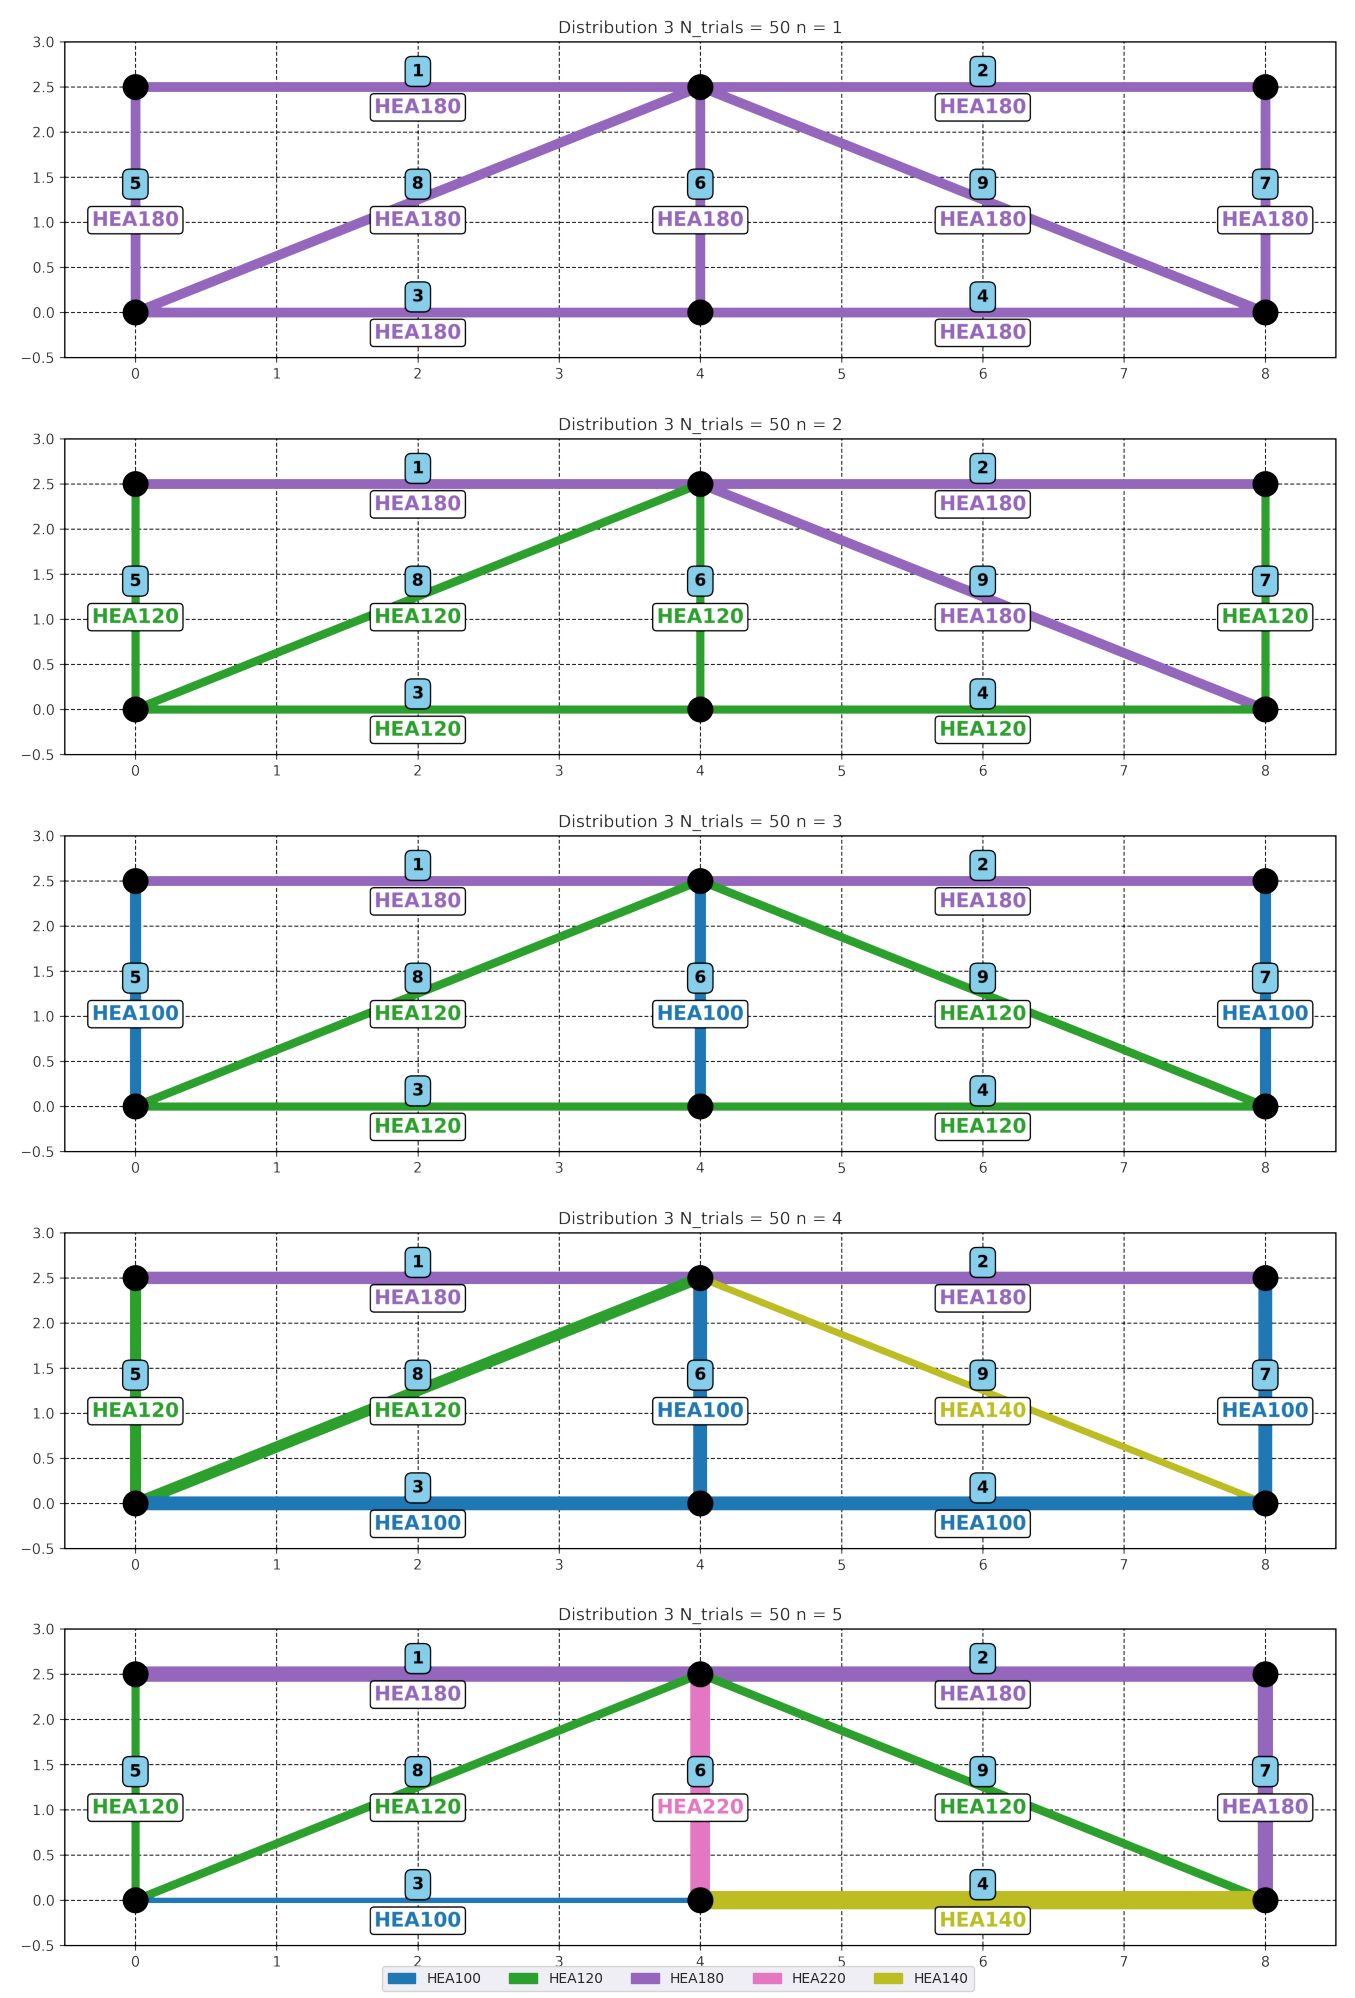

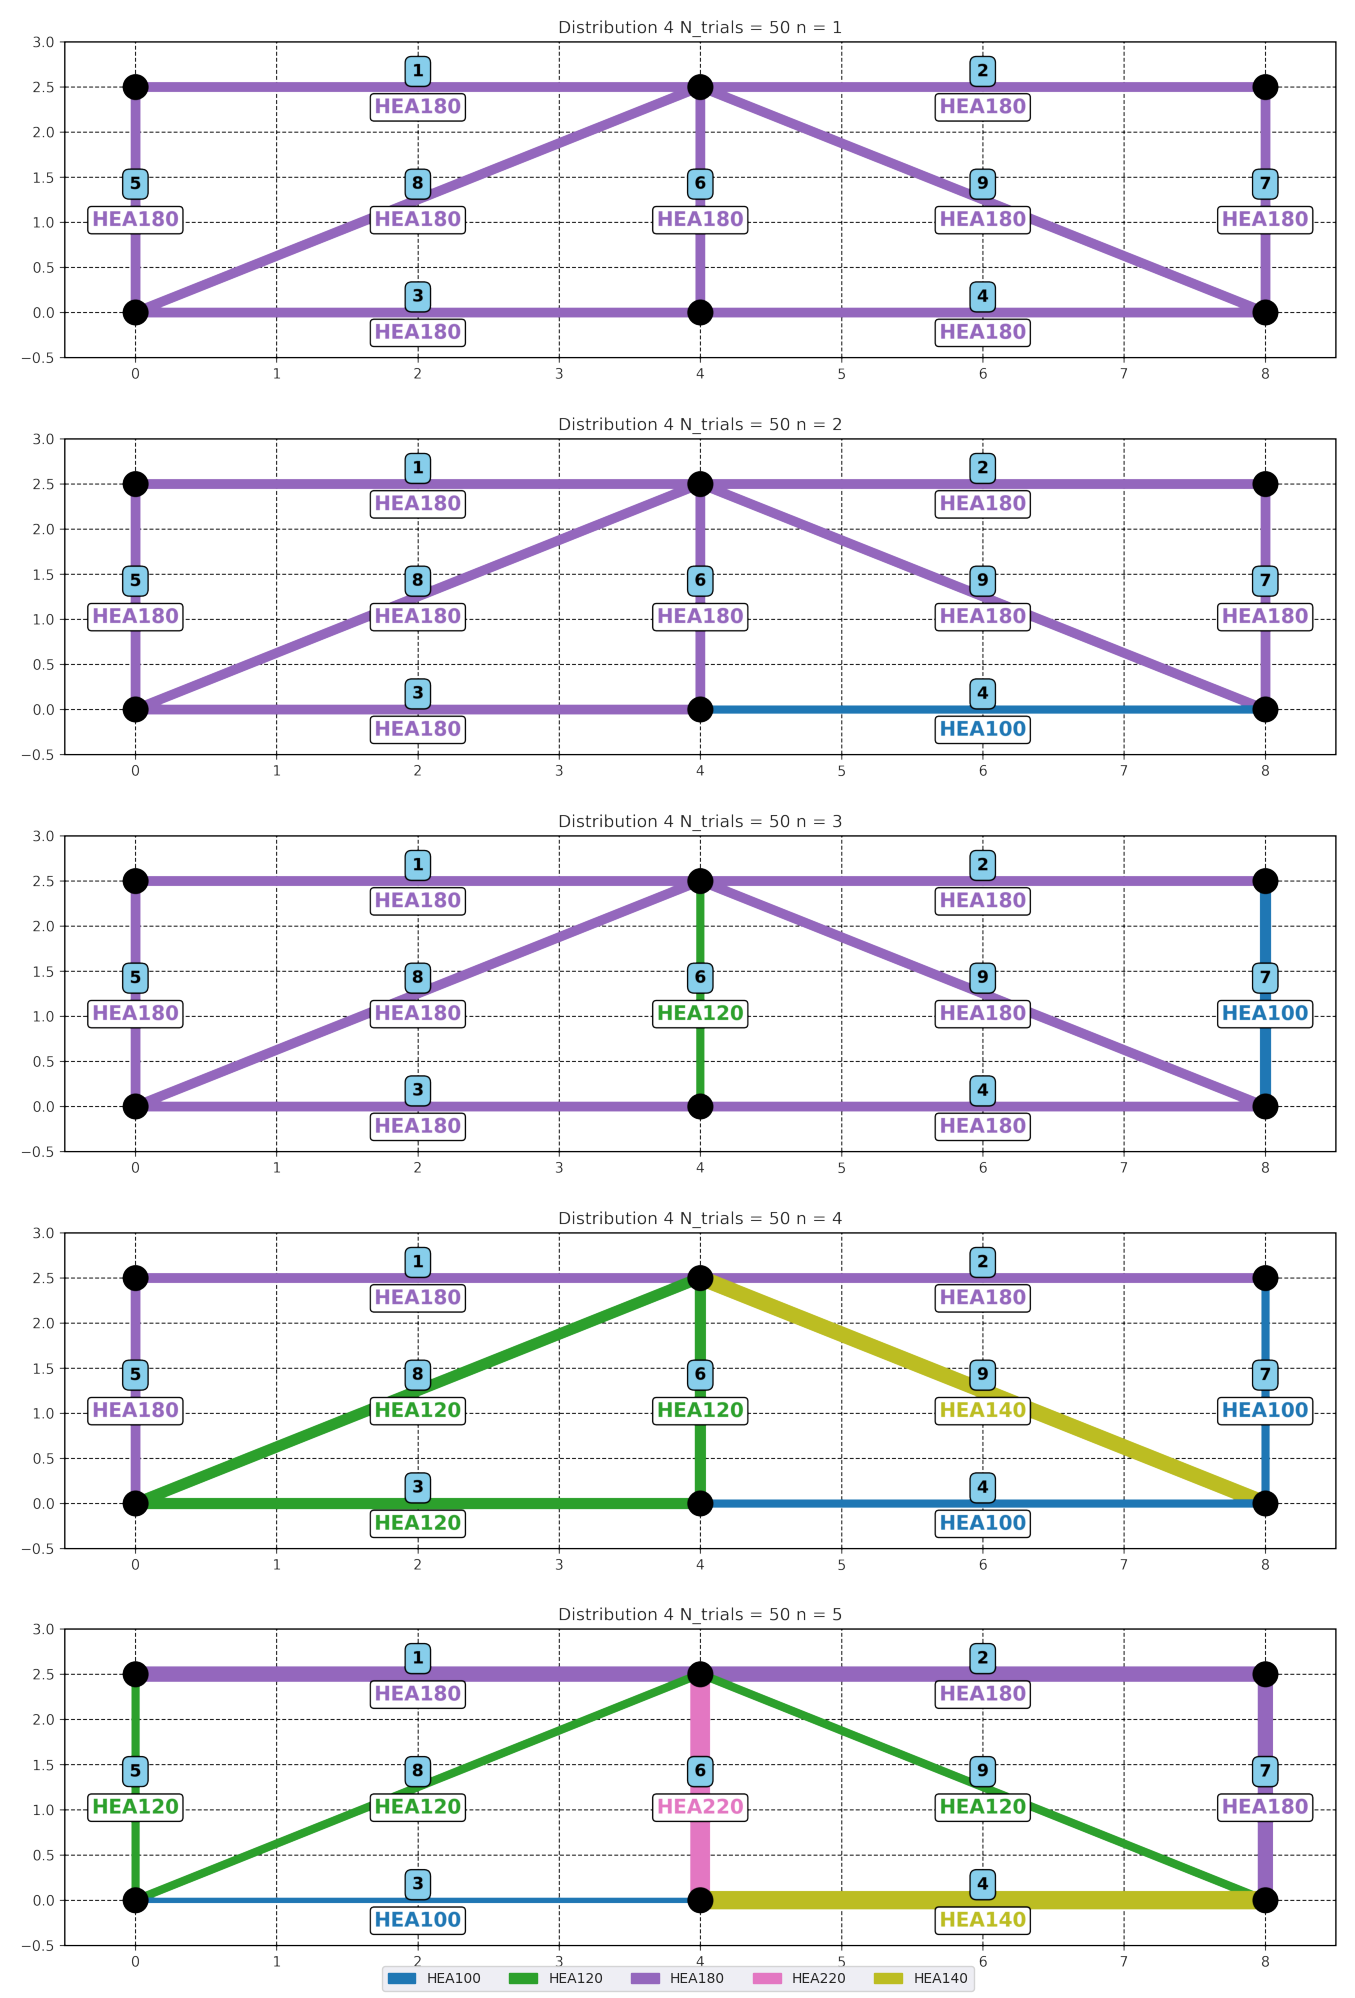

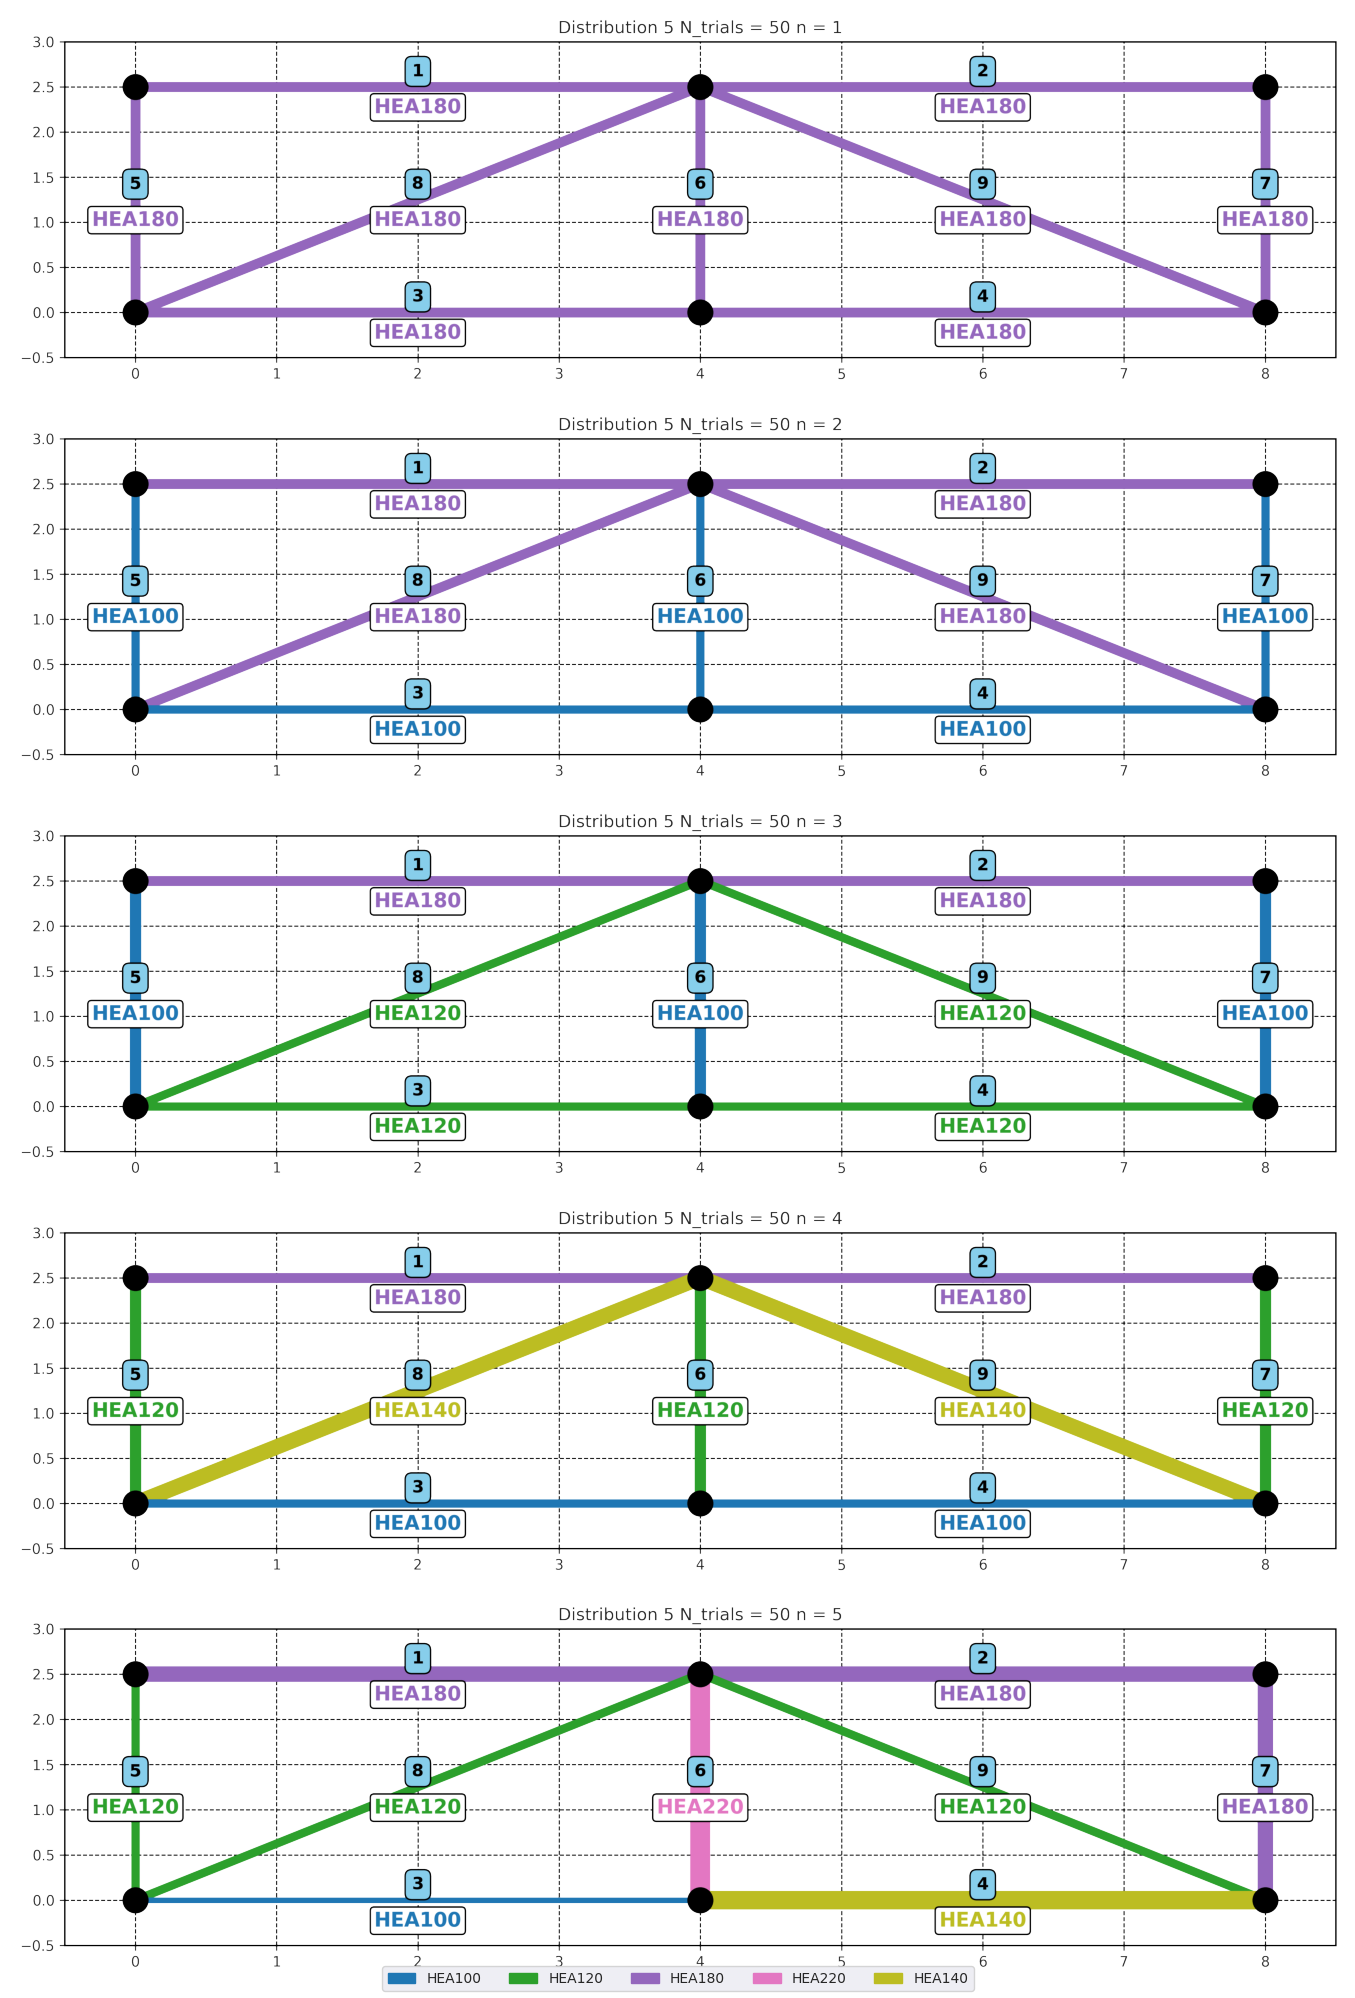

In [15]:
# Function to extract number from truss type labels
def extract_number(truss_label):
    match = re.search(r'HEA(\d+)', truss_label)  # Extract digits after "HEA"
    return int(match.group(1)) if match else 2  # Default to 2 if no match

def plot_graph(G, save=True, edge_colors_map=None, n_dist=0, n_id=0, is_title=True):
    # Create figure and axis with larger size for better visibility
    fig, ax = plt.subplots(figsize=(16, 4))

    # Extract node positions from the 'pos' attribute
    pos = nx.get_node_attributes(G, 'pos')

    # Extract edge attributes
    elements_id_labels = nx.get_edge_attributes(G, 'element_id')
    truss_types_labels = nx.get_edge_attributes(G, 'truss_type')
     # Access colormap correctly
    colormap = plt.colormaps['tab10']  # Access 'tab10' colormap
    unique_truss_types = list(set(truss_types_labels.values()))

    truss_width_map = {truss: extract_number(truss) // 25 + i * 2 for i, truss in enumerate(unique_truss_types)} ### Edge thickness

    # Assign thickness using the mapping
    edge_thickness = [truss_width_map[truss_types_labels[edge]] for edge in G.edges()]

    # If no external edge_colors_map is provided, create it
    if edge_colors_map is None:
        edge_colors = [colormap(i / len(truss_types)) for i in range(len(truss_types))]
        edge_colors_map = {truss: edge_colors[i] for i, truss in enumerate(truss_types)}

    # Assign colors to edges based on 'truss_type'
    edge_colors = [edge_colors_map[truss_types_labels[edge]] for edge in G.edges()]

    # Concatenate 'element_id' and 'truss_type' for edge labeling
    edge_labels = {
        key: f"{str(elements_id_labels[key])}_{str(truss_types_labels[key])}"
        for key in elements_id_labels
    }

    # Make grid and axes visible BEFORE drawing the graph
    ax.grid(True, linestyle="--", alpha=1, color='#000')
    ax.set_facecolor("none")  # White background
    ax.set_axis_on()

    # Ensure axes are visible
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor("black")
        spine.set_linewidth(1.2)

    # Draw the graph (without node labels)
    nx.draw_networkx(G,
                     pos,
                     ax=ax,
                     with_labels=False,
                     node_color="black",
                     edge_color=edge_colors,
                     width=edge_thickness,
                     node_size=300) ### NODE SIZE

    # Manually place the edge labels (both element_id and truss_type)
    for (start, end), label in edge_labels.items():
        x_start, y_start = pos[start]
        x_end, y_end = pos[end]
        x = (x_start + x_end) / 2  # Position in the middle of the edge
        y = (y_start + y_end) / 2

        # Split label into element_id and truss_type
        element_label, truss_label = label.split('_')

        edge_color = edge_colors_map[truss_types_labels[(start, end)]]

        # Style for element_id label
        ax.text(x, y + 0.08, element_label, ha='center', va='bottom', fontsize=12, fontweight="bold", color="black",
                bbox=dict(facecolor='skyblue', edgecolor='black', boxstyle="round,pad=0.4"))

        # Style for truss_type label (more space below the element_id)
        ax.text(x, y - 0.12, truss_label, ha='center', va='top', fontsize=14, fontweight="bold", color=edge_color,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle="round,pad=0.2"))

    ax.set_xlim(min(x for x, y in pos.values()) - 0.5, max(x for x, y in pos.values()) + 0.5)
    ax.set_ylim(min(y for x, y in pos.values()) - 0.5, max(y for x, y in pos.values()) + 0.5)

    if is_title:
        ax.set_title(f"Distribution {n_dist+1} N_trials = {N_TRIALS} n = {n_id}")

    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    fig.patch.set_alpha(0)
    if not save:
        # Show the plot
        plt.show()
    else:
        return ax

def plot_pie_chart(pie_data, save=True):
    pie_data['label'] = ['Mass', 'Connection degree', 'Symmetry', 'Beam continuity']

    colors = sns.color_palette('pastel')[0:4]  # Adjusting the number of colors to match the number of slices
    fig, ax = plt.subplots()

    # Create the pie chart without labels near the slices
    wedges, texts, autotexts = ax.pie(pie_data['values'], labels=[""] * 4, autopct='%.0f%%', colors=colors)

    # Add a legend outside the pie chart
    ax.legend(wedges, pie_data['label'], title="Categories", loc="center left", bbox_to_anchor=(1, 0.5))

    if not save:
        plt.show()
    else:
        # Save the figure to a temporary buffer
        buf = io.BytesIO()
        fig.savefig(buf, format='png', bbox_inches='tight')  # Added bbox_inches='tight' to prevent cutoffs
        buf.seek(0)
        img = Image.open(buf)
        return img  # Return the image object

def plot_line(weights, data, feature_to_plot='weighted_score'):
    labels = ['Mass [kg]', 'Connection degree [-]', 'Symmetry [-]', 'Beam continuity [-]']
    w_len = len(weights[0])
    num_rows = len(data)

    line_x = pd.Series(data['N'].unique())

    plots = []  # Store figures if you need multiple plots

    for k in range(min(num_rows // w_len - 1, len(weights))):
        line_y = pd.Series()
        for i in range(k, num_rows, w_len):
            line_y = pd.concat([line_y, pd.Series([data.iloc[i][feature_to_plot]])])

        # Create a new figure for each line
        fig = go.Figure()
        formatted_values = line_y.round(2)

         # Add the trace with values on the line
        fig.add_trace(go.Scatter(
            x=line_x,
            y=line_y,
            mode='lines+text',  # 'lines+text' adds the text on the line
            name=f"{weights[k]}",
            text=formatted_values,  # The values to display at each data point
            textposition='top center',  # Position the text above the data points
            line=dict(color='blue', width=2),  # Optional: Customize the line color and width
            textfont=dict(color='black', size=20, weight='bold'),  # Set the text color to black
            # Adjust the text position slightly above the line to avoid overlap
            showlegend=False,  # Hide the legend for this trace
        ))

        label = ""
        if feature_to_plot == 'mass':
            label = labels[0]
        elif feature_to_plot == 'connect_deg':
            label = labels[1]
        elif feature_to_plot == 'symmetry':
            label = labels[2]
        elif feature_to_plot == 'beam_cont':
            label = labels[3]

        # Customize layout with larger width, white background, and no grid
        fig.update_layout(
            height=700,  # Height of the plot
            width=1200,  # Width of the plot
            xaxis_title="Number of configurations (n)",
            yaxis_title=label,
            legend_title="Distributions",
            xaxis=dict(
                tickmode='linear',
                tick0=1,
                dtick=1,
                mirror=True,
                showline=True,  # Show the x-axis line
                linecolor='black',  # Color of the x-axis line
                linewidth=2,  # Line width of the x-axis line
                title=dict(text="Number of configurations (n)", font=dict(size=30, weight='bold')),
                griddash='dash',
            ),
            yaxis=dict(
                mirror=True,
                showline=True,  # Show the y-axis line
                linecolor='black',  # Color of the y-axis line
                linewidth=2,  # Line width of the y-axis line
                title=dict(text=label, font=dict(size=30, weight='bold')),
                griddash='dash',
            ),
            plot_bgcolor='rgba(0,0,0,0)',  # Set plot background to white
            paper_bgcolor='rgba(0,0,0,0)',  # Set the background of the entire paper to white
            font=dict(color='black', size=25)  # Set the font color for axis titles and other text to black
        )

        fig.update_xaxes(showgrid=True)
        fig.update_yaxes(showgrid=True)
        fig.add_shape(
            type="rect",
            xref="paper", yref="paper",  # Use "paper" to cover the full area
            x0=0, x1=1,  # Covers the entire width
            y0=0, y1=1,  # Covers the entire height
            line=dict(color="black", width=2)) # Black border

        # Show the plot immediately if required
        # fig.show()

        # Store the figure in case you want to return it
        plots.append(fig)

    return plots

def save_plots(is_title=True, experiment_name=""):
    # Define the directory to save images
    save_dir = "plots"
    os.makedirs(save_dir, exist_ok=True)  # Create directory if it doesn't exist

    truss_types = parallel_coordinates_data[[f"s_{i}" for i in range(1, N_PROFILES+1)]]
    weights_data = parallel_coordinates_data[[f"w_{i}" for i in range(1, 5)]]

    graphs = []
    pie_charts = []

    mass_plots = plot_line(WEIGHTS, parallel_coordinates_data, feature_to_plot='mass')
    connectivity_plots = plot_line(WEIGHTS, parallel_coordinates_data, feature_to_plot='connect_deg')
    symmetry_plots = plot_line(WEIGHTS, parallel_coordinates_data, feature_to_plot='symmetry')
    beam_cont_plots = plot_line(WEIGHTS, parallel_coordinates_data, feature_to_plot='beam_cont')
    unique_weights_conf = weights_data.drop_duplicates()

    unique_truss_types = list(set(truss_types.values.flatten().tolist()))
    colormap = plt.colormaps['tab10']
    edge_colors = [colormap(i / len(unique_truss_types)) for i in range(len(unique_truss_types))]
    edge_colors_map = {truss: edge_colors[i] for i, truss in enumerate(unique_truss_types)}

    counter = 1
    for i in range(len(truss_types)):
        truss_types_conf = pd.DataFrame(truss_types.iloc[i].values.flatten(), columns=['values'])

        G, data_nodes = create_graph(nodes_1, nodes_2, nodes_1_coord, nodes_2_coord, truss_types_conf)

        graph_to_be_plotted = plot_graph(G,
                                         save=True,
                                         edge_colors_map=edge_colors_map,
                                         is_title=True,   ############################### Deconecteaza titlul
                                         n_dist=i % len(WEIGHTS),
                                         n_id=counter)

        graphs.append(graph_to_be_plotted)

        if i % 5 == 0 and i != 0:  # Every 5 iterations
            counter += 1

    for i in range(len(unique_weights_conf)):
        unique_weight_conf = pd.DataFrame(unique_weights_conf.iloc[i].values.flatten(), columns=['values'])
        pie_chart = plot_pie_chart(unique_weight_conf)
        pie_charts.append(pie_chart)

    for j in range(len(mass_plots)):
        fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(16, 20))  # Adjust height as needed

        mass_plot = mass_plots[j].to_image(format="png")
        connectivity_plot = connectivity_plots[j].to_image(format="png")
        symmetry_plot = symmetry_plots[j].to_image(format="png")
        beam_cont_plot = beam_cont_plots[j].to_image(format="png")
        pie_chart = pie_charts[j]

        # Save images to temporary files
        mass_plot_path = os.path.join(save_dir, f"mass_plot_{i}.png")
        connectivity_plot_path = os.path.join(save_dir, f"connectivity_plot_{i}.png")
        symmetry_plot_path = os.path.join(save_dir, f"symmetry_plot_{i}.png")
        beam_cont_plot_path = os.path.join(save_dir, f"beam_cont_plot_{i}.png")

        with open(mass_plot_path, "wb") as f:
            f.write(mass_plot)
        with open(connectivity_plot_path, "wb") as f:
            f.write(connectivity_plot)
        with open(symmetry_plot_path, "wb") as f:
            f.write(symmetry_plot)
        with open(beam_cont_plot_path, "wb") as f:
            f.write(beam_cont_plot)

        # Plot the Pie Chart Image in Matplotlib
        axs[0].imshow(pie_chart)
        axs[0].axis("off")  # Hide axes for the pie chart
        axs[0].set_title(f"Distribution {j} N_trials = {N_TRIALS}")

        # Load the line plot images with Matplotlib
        axs[1].imshow(mpimg.imread(mass_plot_path))
        axs[1].axis("off")  # Hide axes for the line plot

        axs[2].imshow(mpimg.imread(connectivity_plot_path))
        axs[2].axis("off")

        axs[3].imshow(mpimg.imread(symmetry_plot_path))
        axs[3].axis("off")

        axs[4].imshow(mpimg.imread(beam_cont_plot_path))
        axs[4].axis("off")

        # Adjust spacing for better layout
        plt.tight_layout()

        dest_to_save = os.path.join(save_dir, experiment_name, f'n_profiles_{N_PROFILES}_distribution_{j+1}_n_trials_{N_TRIALS}')
        os.makedirs(dest_to_save, exist_ok=True)
        # Save the stacked figure
        fig.savefig(os.path.join(dest_to_save, f"pie_line_plot.png"), dpi=300, bbox_inches='tight')
        plt.close(fig)  # Close figure to prevent memory issues

        # Delete the intermediate plot files
        os.remove(mass_plot_path)
        os.remove(connectivity_plot_path)
        os.remove(symmetry_plot_path)
        os.remove(beam_cont_plot_path)

    for n_idx in range(len(WEIGHTS)):
        figure, axs = plt.subplots(nrows=5, ncols=1, figsize=(16, 20))  # Adjust height as needed

        dest_to_save = os.path.join(save_dir, experiment_name, f'n_profiles_{N_PROFILES}_distribution_{n_idx+1}_n_trials_{N_TRIALS}')
        plt.subplots_adjust(bottom=0.1)
        for j, distribution_idx in enumerate(range(n_idx, len(graphs), len(WEIGHTS))):

            fig = graphs[distribution_idx].get_figure() if hasattr(graphs[distribution_idx], 'get_figure') else graphs[distribution_idx]

            # Load the line plot images with Matplotlib
            fig.savefig(os.path.join(dest_to_save, f"graph_n_{j+1}.png"), dpi=300, bbox_inches='tight')
            axs[j].imshow(mpimg.imread(os.path.join(dest_to_save, f"graph_n_{j+1}.png")))

            axs[j].axis("off")

            plt.close(fig)
        legend_entries = [mpatches.Patch(color=color, label=truss) for truss, color in edge_colors_map.items()]

        figure.legend(handles=legend_entries, loc='lower center', ncol=5)
        plt.tight_layout()
        figure.savefig(os.path.join(dest_to_save, f"stacked_graph.png"), dpi=300, bbox_inches='tight', transparent=True)

# save_plots(experiment_name="test_1")


In [ ]:
create_graph()